In [116]:
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.stats import mannwhitneyu
from scipy.stats import levene
from scipy.stats import kruskal
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.graphics.gofplots import qqplot

In [4]:
weights = pd.read_csv("./results/hlr.settles.acl16.learning_traces.13m.weights",delimiter='\t',skiprows=3,header=None)

In [5]:
weights.columns = ['lexemes','weights']

In [6]:
weights.head()

,lexemes,weights
0,es:desde/desde<pr>,0.1707
1,es:como/comer<vblex><pri><p1><sg>,0.1708
2,de:kinder/kind<n><nt><pl><nom>,0.1297
3,en:strawberry/strawberry<n><sg>,-0.0585
4,en:to/to<pr>,0.0324


In [7]:


# Function to split the column into four parts
def split_column(row):
    parts = row['lexemes'].split(':')
    row['lang'] = parts[0] 
    parts = parts[1].split('/')
    row['surface_form'] = parts[0]
    parts = parts[1].split('<')
    row['root'] = parts[0]
    row['tags'] = parts[1:]
    return row   

# Apply the function to the dataframe and drop the original column
df = weights.apply(split_column, axis=1).drop('lexemes', axis=1)




In [6]:
def handle_sf(row):
    if row.surface_form == '<*sf>':
        row.surface_form = row.root
    return row

In [7]:
df = df.apply(handle_sf,axis=1)

In [8]:
df.head()

,weights,lang,surface_form,root,tags
0,0.1707,es,desde,desde,[pr>]
1,0.1708,es,como,comer,"[vblex>, pri>, p1>, sg>]"
2,0.1297,de,kinder,kind,"[n>, nt>, pl>, nom>]"
3,-0.0585,en,strawberry,strawberry,"[n>, sg>]"
4,0.0324,en,to,to,[pr>]


# Length Analysis

count    335.000000
mean       0.049811
std        0.187970
min       -0.513200
25%       -0.068700
50%        0.052200
75%        0.169050
max        0.675100
Name: weights, dtype: float64
count    18944.000000
mean         0.135151
std          0.203082
min         -0.771300
25%          0.000000
50%          0.130000
75%          0.272525
max          0.772200
Name: weights, dtype: float64
count    1113.00000
mean        0.09557
std         0.20383
min        -0.51320
25%        -0.04310
50%         0.10420
75%         0.22620
max         0.67510
Name: weights, dtype: float64
count    18166.000000
mean         0.136002
std          0.202861
min         -0.771300
25%          0.000400
50%          0.130000
75%          0.273400
max          0.772200
Name: weights, dtype: float64
count    2901.000000
mean        0.130823
std         0.209972
min        -0.550700
25%        -0.006300
50%         0.130400
75%         0.275800
max         0.719800
Name: weights, dtype: float64
count    1

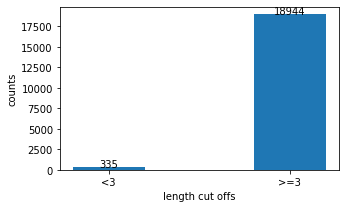

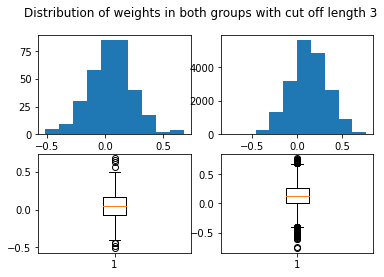

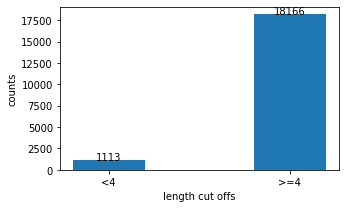

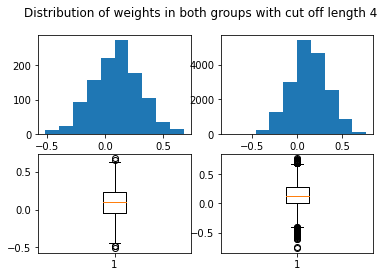

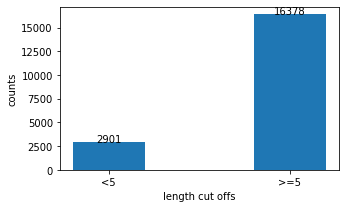

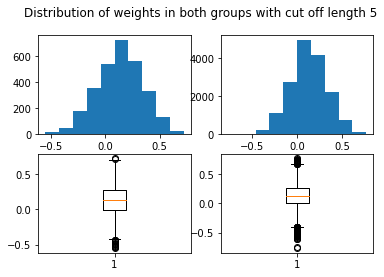

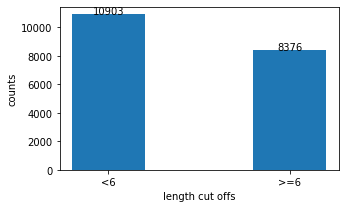

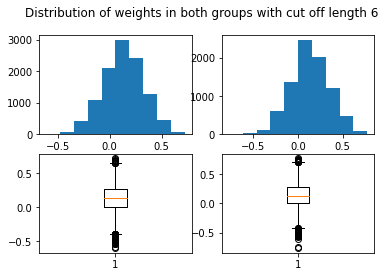

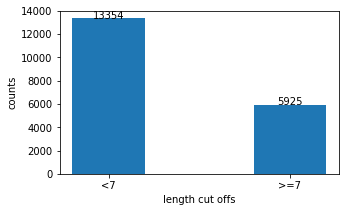

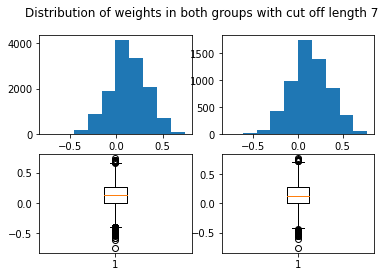

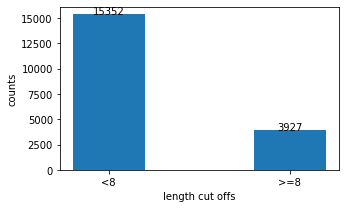

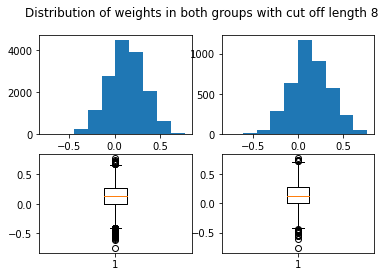

In [122]:
lengths = [3,4,5,6,7,8]
pvalues = []
ss = []
temp = df['surface_form'].apply(lambda x : len(x))

for length in lengths:
    group1 = df[temp < length]
    group2 = df[temp >= length]

    values = [len(group1),len(group2)]
    labels = [f"<{length}",f">={length}"]
    plt.figure(figsize=(5,3))
    plt.bar(labels,values,width=0.4)
    for i in range(len(labels)):
        plt.text(i, values[i], values[i], ha = 'center')
    plt.ylabel("counts")
    plt.xlabel("length cut offs")

    fig,axes = plt.subplots(2,2)
    axes[0,0].hist(group1.weights)
    axes[0,1].hist(group2.weights)

    axes[1,0].boxplot(group1.weights)
    axes[1,1].boxplot(group2.weights)

    fig.suptitle(f"Distribution of weights in both groups with cut off length {length}")

    print(group1.weights.describe())
    print(group2.weights.describe())

    result = mannwhitneyu(group1.weights,group2.weights,alternative='less')
    pvalues.append(result.pvalue)
    ss.append(result.statistic)

In [123]:
ss

[2376682.0, 8932579.5, 23658652.5, 44613272.0, 38857568.0, 29705395.0]

Text(0, 0.5, 'p values')

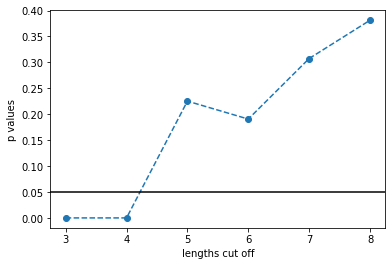

In [236]:
plt.plot(lengths,pvalues,linestyle='dashed',marker="o")
plt.axhline(0.05,color='black')
plt.xlabel("lengths cut off")
plt.ylabel("p values")

Text(0.5, 1.0, 'distribution of length of words')

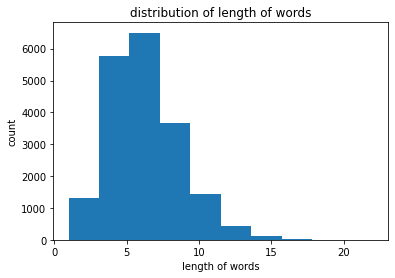

In [123]:
plt.hist(temp)
plt.xlabel("length of words")
plt.ylabel("count")
plt.title("distribution of length of words")

# Language Analysis

## Non parametric anova

In [165]:
df.lang.value_counts().values

array([4184, 3809, 3302, 2983, 2815, 2186])

Text(0.5, 0, 'languages')

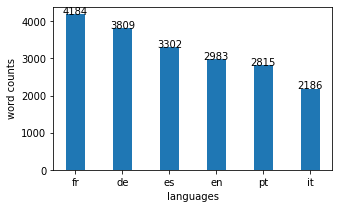

In [124]:
values = df.lang.value_counts().values
labels = df.lang.value_counts().index
plt.figure(figsize=(5,3))
plt.bar(labels,values,width=0.4)
for i in range(len(labels)):
    plt.text(i, values[i], values[i], ha = 'center')
plt.ylabel("word counts")
plt.xlabel("languages")

In [125]:
language_df = {}

for name,group in df.groupby('lang'):
    language_df[name] = list(group.weights)

Text(0.5, 0.98, 'Distribution of weights across languages')

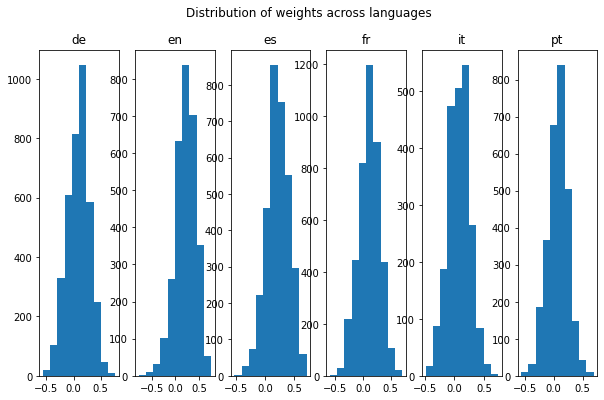

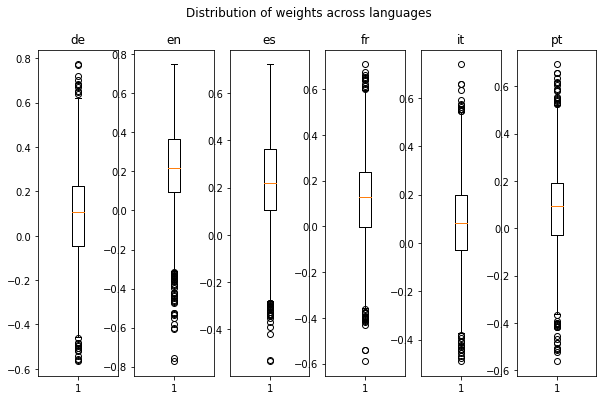

In [126]:
languages = list(language_df.keys())
weights_lang = list(language_df.values())

fig,axs = plt.subplots(1,6,figsize=(10,6))
for i in range(6):
    axs[i].hist(weights_lang[i])
    axs[i].set_title(languages[i])
fig.suptitle("Distribution of weights across languages")

fig,axs = plt.subplots(1,6,figsize=(10,6))
for i in range(6):
    axs[i].boxplot(weights_lang[i])
    axs[i].set_title(languages[i])
fig.suptitle("Distribution of weights across languages")


In [197]:
pip install scikit_posthocs

  Using cached statsmodels-0.13.5-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.9 MB)
  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
     |████████████████████████████████| 48 kB 2.7 MB/s eta 0:00:01
  Using cached patsy-0.5.3-py2.py3-none-any.whl (233 kB)


In [194]:
levene(*weights)

LeveneResult(statistic=25.853594718694723, pvalue=4.181738745727828e-26)

In [196]:
kruskal(*weights)

KruskalResult(statistic=1719.2211728692748, pvalue=0.0)

In [128]:
import scikit_posthocs as sp 

results = sp.posthoc_mannwhitney(weights_lang,p_adjust='bonferroni')

Text(0.5, 1.0, 'Statistical Signficance')

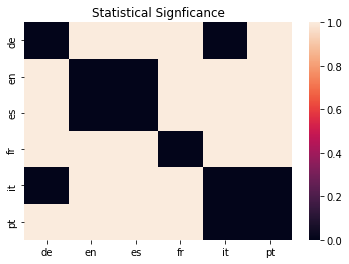

In [129]:
sns.heatmap(results <= 0.05,xticklabels=languages,yticklabels=languages)
plt.title("Statistical Signficance")

In [135]:
import numpy as np 
weights_lang_avg = []
for i in range(len(weights_lang)):
    weights_lang_avg.append(np.mean(weights_lang[i]))

In [156]:
A = weights_lang_avg
n = len(A)
result = []
for i in range(n):
    row = []
    for j in range(n):
        diff = A[i] - A[j]
        row.append(round(diff,3))
    result.append(row)

In [157]:
report = pd.DataFrame(result)
report.columns = languages
report.index = languages

In [158]:
report

,de,en,es,fr,it,pt
de,0.000,-0.124,-0.131,-0.025,0.012,0.015
en,0.124,0.000,-0.007,0.099,0.136,0.140
es,0.131,0.007,0.000,0.106,0.144,0.147
fr,0.025,-0.099,-0.106,0.000,0.037,0.040
it,-0.012,-0.136,-0.144,-0.037,0.000,0.003
pt,-0.015,-0.140,-0.147,-0.040,-0.003,0.000


## Linear Regression

In [93]:
encoder = OneHotEncoder()
onehot = encoder.fit_transform(df[['lang']]).toarray()
# encoded_df = pd.DataFrame(onehot, columns=encoder.get_feature_names_out(['color']))
feature_names = encoder.get_feature_names_out(['lang'])

encoded_df = pd.DataFrame(onehot, columns=feature_names)

In [94]:
X = encoded_df.iloc[:,1:6]

In [95]:
X = sm.add_constant(X)

In [159]:
X.head()

,const,lang_en,lang_es,lang_fr,lang_it,lang_pt
0,1.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0


In [120]:
model = sm.OLS(df["weights"], X).fit()

In [22]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                weights   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     372.1
Date:                Sat, 06 May 2023   Prob (F-statistic):               0.00
Time:                        11:07:51   Log-Likelihood:                 4262.1
No. Observations:               19279   AIC:                            -8512.
Df Residuals:                   19273   BIC:                            -8465.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0902      0.003     28.692      0.0

In [51]:
from scipy.stats import f_oneway

In [52]:
f_oneway(*weights_lang)

F_onewayResult(statistic=372.14720195993715, pvalue=0.0)

In [25]:
ncvTest = het_breuschpagan(model.resid,  model.model.exog)
print('White test for heteroscedasticity:')
print('F-statistic:', ncvTest[0])
print('p-value:', ncvTest[1])
print('Degrees of freedom:', ncvTest[2])

White test for heteroscedasticity:
F-statistic: 137.24778239938422
p-value: 6.879508344920865e-28
Degrees of freedom: 27.637767745746245


Text(0, 0.5, 'residuals')

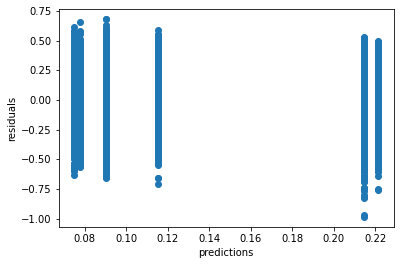

In [16]:
preds = model.predict(X)
plt.plot(preds,model.resid,"o")
plt.xlabel("predictions")
plt.ylabel("residuals")

In [114]:
model2 = sm.OLS(df["weights"],X).fit(cov_type='HC3')

In [115]:
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                weights   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     366.7
Date:                Sat, 06 May 2023   Prob (F-statistic):               0.00
Time:                        13:09:36   Log-Likelihood:                 4262.1
No. Observations:               19279   AIC:                            -8512.
Df Residuals:                   19273   BIC:                            -8465.
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0902      0.003     27.187      0.0

Text(0, 0.5, 'residuals')

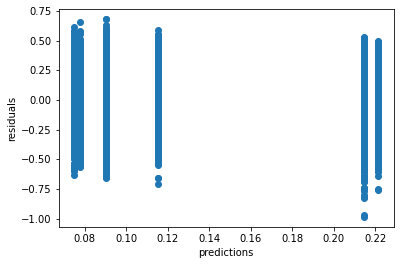

In [111]:
preds = results.predict(X)
plt.plot(preds,results.resid,"o")
plt.xlabel("predictions")
plt.ylabel("residuals")

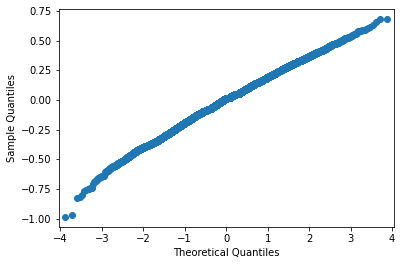

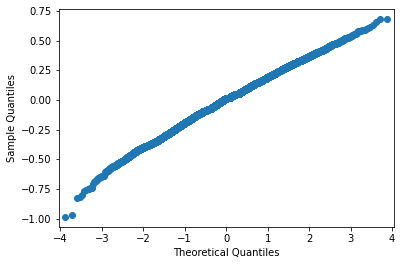

In [117]:
qqplot(model2.resid)

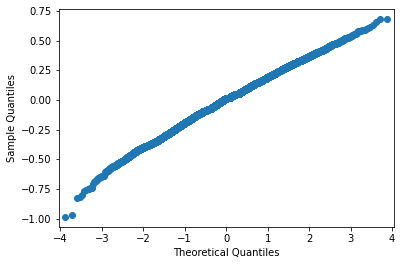

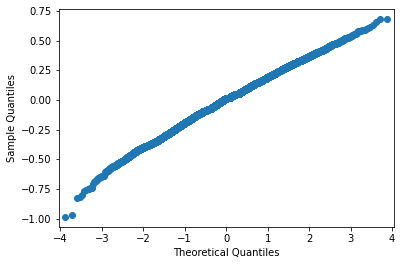

In [121]:
qqplot(model2.resid)